

<center>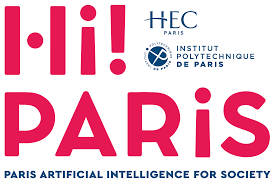</center>

___


### The Goal of this notebook is to optimise low rank estimation:
 
### Structure of the Script:
* <b>Input:</b> matrice
* <b>Output:</b> error_low_rank, error_empirical
* <b>Method:</b> 
    * generate_low_rank_samples():
        * has four parameters: d1,d2,K,n
        * returns tuple of (res, Y1/n, Y2/n)
    * generate_dirichlet_low_rank_samples(): 
        * has six parameters: d1,d2,K,n,diric1,diric2
        * returns tuple of (res,Y1/n, Y2/n)
    * our_algo():
        * has six parameters: n,Y1,Y2,alpha,cstar,Cbar
        * returns res/np.sum(res)
    * loss_calculation() - returns two values: error_low_rank, error_empirical

### Current Scope: 
This notebook is estimation procedure. But we have to do otimisation for multi-dimension density estimation procedure as well

-----

# Table Of Content
* I - [Import of Packages](#first-bullet)
* II - [generate_low_rank_samples](#second-bullet)
* III - [generate_dirichlet_low_rank_samples](#third-bullet)
* IV - [our_algo](#fourth-bullet)
* V - [loss_calculation](#fifth-bullet)


## I - Import of Packages <a class="anchor" id="first-bullet"></a>

In [7]:
#group 1
import sys # lets us access system-specific parameters and functions

#group 2
import numpy as np # Python library used for working with multi-dimensional array and matrix data structures
import matplotlib.pyplot as plt #functions that make matplotlib work like MATLAB
from numba import njit
np.random.seed(1) 

## II - generate_low_rank_samples <a class="anchor" id="second-bullet"></a>

In [9]:
@njit
def generate_low_rank_samples(d1,d2,K,n):
    '''
    The goal of this function is to generate two low-rank matrices with dimensions d1 and d2, 
    using a random combination of vectors u and v.
    
    parameters:
    ----
    d1: int
    size of the matrice 
    
    d2: int
    size of the matrice 
    
    K: int
    loop repetition
    
    n: int
    sample size
    
    Return:
    ----
    
    res,Y1/n, Y2/n : it is returned in tuple format
    
    res: numpy.ndarray
    a matrix of size d1 by d2
    
    Y1/n: numpy.ndarray
    a matrix obtained by generating a multinomial distribution with n samples 
    and a probability distribution derived from a low-rank matrix
    
    Y2/n: numpy.ndarray
    a matrix obtained by generating a multinomial distribution with n samples 
    and a probability distribution derived from a low-rank matrix
    
    '''
    res = np.zeros((d1,d2)) 
    for k in range(K): 
        u = np.random.rand(d1,1) 
        v = np.random.rand(d2,1)
        res += 1/K * u.dot(v.T)
    P = res/np.sum(res) 
    p = np.reshape(P,d1*d2)
    X  = np.random.multinomial(n,p)
    Y1 = np.reshape(X,(d1,d2)) 
    X  = np.random.multinomial(n,p)
    Y2 = np.reshape(X,(d1,d2)) 
    
    return(res,Y1/n, Y2/n)

## III - generate_dirichlet_low_rank_samples <a class="anchor" id="third-bullet"></a>

In [10]:
@njit
def generate_dirichlet_low_rank_samples(d1,d2,K,n,diric1,diric2):
    '''
    The goal of this function is to generate two low-rank matrices with dimensions d1 and d2, 
    using a random combination of vectors u and v, using Dirichlet distribution.
    
    parameters:
    ----
    d1: int
    size of the matrice  
    
    d2: int
    size of the matrice 
    
    K: int
    loop repetition
    
    n: int
    sample size
    
    diric1: float
    to apply dirichlet distribution
    
    diric2: float
    to apply dirichlet distribution
    
    Return:
    ----
    
    res,Y1/n, Y2/n : it is returned in tuple format
    
    res: numpy.ndarray
    a matrix of size d1 by d2
    
    Y1/n: numpy.ndarray
    a matrix obtained by generating a multinomial distribution with n samples 
    and a probability distribution derived from a low-rank matrix. Y1/n is used for scaling
    
    Y2/n: numpy.ndarray
    a matrix obtained by generating a multinomial distribution with n samples 
    and a probability distribution derived from a low-rank matrix. Y2/n is used for scaling
    
    '''
    res = np.zeros((d1,d2))
    for k in range(K):
        u = np.random.dirichlet(diric1*np.ones(d1),1)
        v = np.random.dirichlet(diric2*np.ones(d2),1)
        res += 1/K * u.T.dot(v)
    p = np.reshape(res,d1*d2)
    X  = np.random.multinomial(n,p)
    Y1 = np.reshape(X,(d1,d2))
    X  = np.random.multinomial(n,p)
    Y2 = np.reshape(X,(d1,d2))
    
    return(res,Y1/n, Y2/n)

## IV - our_algo <a class="anchor" id="fourth-bullet"></a>

In [11]:
@njit
def our_algo(n,Y1,Y2,alpha,cstar,Cbar):
    '''
    The goal of this function is to return low rank matrix using singular value decomposition and thresholding
    
    parameters:
    ----
    
    n: int
    sample size
    
    Y1: numpy.ndarray
    a matrix obtained by generating a multinomial distribution with n samples 
    and a probability distribution derived from a low-rank matrix
    
    Y2: numpy.ndarray
    a matrix obtained by generating a multinomial distribution with n samples 
    and a probability distribution derived from a low-rank matrix
    
    alpha: float
    tuning parameter
    
    cstar: float
    a constant
    
    Cbar: float
    tuning parameter
    
    Return:
    ----
    
    res/np.sum(res): numpy.ndarray
    for scaling the res matrix

    
    '''
    (d1,d2) = np.shape(Y1) 
    d = max(d1,d2) 

    if (n <= d*np.log(d)):
        return((Y1+Y2)/2)
      
    else:
        res = np.zeros((d1,d2))
        T = int(np.log(d)/np.log(2))
        p = np.sum(Y1, axis=1)
        q = np.sum(Y1, axis=0)

        for t in range(T+1): 
            if (t<T):
                I = np.argwhere((p <= 2**(-t)) & (p > 2**(-t-1)))

            else: 
                I = np.argwhere((p <= 2**(-t)))

            for u in range(T+1): 
                if (u<T):
                    J = np.argwhere((q <= 2**(-u)) & (q > 2**(-u-1))) 
                else: 
                    J = np.argwhere(q <= 2**(-u))
                #M = np.zeros(np.shape(Y2))  
                M = np.zeros((len(I),len(J))) 
                #for i in range(len(I)): 
                #    for j in range(len(J)): 
                #        M[i,j] = Y2[I[i],J[j]]
                row_indices = np.zeros(Y2.shape[0], dtype=bool)
                row_indices[I] = True
                col_indices = np.zeros(Y2.shape[1], dtype=bool)
                col_indices[J] = True
                M = Y2[row_indices, :][:, col_indices]

                if (np.sum(M) < 2*Cbar*alpha*np.log(d)/(n*np.log(2))):

                    for i in range(len(I)): # +1
                        for j in range(len(J)):
                            res[I[i],J[j]] = Y2[I[i],J[j]]  

                else:
                    #print((t,u))
                    tau = np.log(d) * np.sqrt(cstar * 2**(1-min(t,u))/n)
                    U,s,Vh = np.linalg.svd(M)
                    l = len(s[s>=tau])
                    #l = 5
                    H = np.dot(U[:,:l]*s[:l], Vh[:l,:])
                    for i in range(len(I)):  # +2
                        for j in range(len(J)):
                            res[I[i],J[j]] = H[i,j]


        return(res/np.sum(res))

## V - loss_calculation  <a class="anchor" id="fifth-bullet"></a>

In [13]:
%%timeit
def loss_calculation():
    '''
    The goal of this function is to is to evaluate the performance of an algorithm for matrix completion
    in the context of low-rank matrix recovery.
    
    Return:
    ----
    error_low_rank: numpy.ndarray
    measure the error difference
    
    error_empirical: numpy.ndarray
    measure the error difference
    

    '''
    
    K = 10
    Cbar = .5
    alpha = .1
    cstar= alpha/10
    beg = 100
    end = 400
    step = 20

    error_low_rank  = np.zeros(len(range(beg,end,step)))
    error_empirical = np.zeros(len(range(beg,end,step)))

    for (i,d) in enumerate(range(beg,end,step)):
        d1 = d
        d2 = d
        n = int(10000*d*np.log(d)**2)
        diric1 = d1/(3*K)
        diric2 = d2/(3*K)
        (P,Y1,Y2) = generate_dirichlet_low_rank_samples(d1,d2,K,n, diric1,diric2)
        #(P,Y1,Y2) = generate_low_rank_samples(d1,d2,K,n, diric1,diric2)
        P_hat = our_algo(n,Y1,Y2,alpha,cstar,Cbar)
        error_low_rank[i] = np.sum(np.abs(P-P_hat))
        error_empirical[i] = np.sum(np.abs(P-Y2))
    return error_low_rank, error_empirical

error_low_rank, error_empirical = loss_calculation()

TypingError: [1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(int64, dtype=Function(<class 'bool'>))
 
There are 4 candidate implementations:
[1m   - Of which 4 did not match due to:
   Overload in function '_OverloadWrapper._build.<locals>.ol_generated': File: numba/core/overload_glue.py: Line 131.
     With argument(s): '(int64, dtype=Function(<class 'bool'>))':[0m
[1m    Rejected as the implementation raised a specific error:
      TypingError: Failed in nopython mode pipeline (step: nopython frontend)
    [1m[1m[1mNo implementation of function Function(<intrinsic stub>) found for signature:
     
     >>> stub(int64, Function(<class 'bool'>))
     
    There are 2 candidate implementations:
    [1m  - Of which 2 did not match due to:
      Intrinsic of function 'stub': File: numba/core/overload_glue.py: Line 35.
        With argument(s): '(int64, Function(<class 'bool'>))':[0m
    [1m   No match.[0m
    [0m
    [0m[1mDuring: resolving callee type: Function(<intrinsic stub>)[0m
    [0m[1mDuring: typing of call at <string> (3)
    [0m
    [1m
    File "<string>", line 3:[0m
    [1m<source missing, REPL/exec in use?>[0m
[0m
  raised from /Users/gaetanbrison/opt/anaconda3/lib/python3.9/site-packages/numba/core/typeinfer.py:1086
[0m
[0m[1mDuring: resolving callee type: Function(<built-in function zeros>)[0m
[0m[1mDuring: typing of call at /var/folders/v_/vcf1lg6d1d517lzpgs2wzyhr0000gn/T/ipykernel_85054/3931997796.py (66)
[0m
[1m
File "../../../../../../../var/folders/v_/vcf1lg6d1d517lzpgs2wzyhr0000gn/T/ipykernel_85054/3931997796.py", line 66:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function our_algo at 0x7fec089a3c10>))[0m
[0m[1mDuring: typing of call at <magic-timeit> (37)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function our_algo at 0x7fec089a3c10>))[0m
[0m[1mDuring: typing of call at <magic-timeit> (37)
[0m

In [37]:
error_empirical

array([0.01722172, 0.01801346, 0.01898817, 0.01992278, 0.0204736 ,
       0.02124961, 0.02185574, 0.02237391, 0.0230842 , 0.0236968 ,
       0.02419112, 0.02478978, 0.02523117, 0.02572429, 0.02622529])

In [38]:
error_low_rank

array([0.01622347, 0.01646942, 0.01603034, 0.01878983, 0.01905644,
       0.01940091, 0.01965256, 0.01958832, 0.01626183, 0.0193328 ,
       0.02216266, 0.02284626, 0.02305689, 0.02321374, 0.02335556])

In [32]:
%lprun -f loss_calculation loss_calculation()

In [15]:
from numba import njit

@njit(forceobj=True)
def outer_function(x, y):
    @njit(forceobj=True)
    def inner_function(a, b):
        return a + b

    return inner_function(x, y)

result = outer_function(1, 2)
print(result)


/Users/gaetanbrison/opt/anaconda3/lib/python3.9/site-packages/numba/core/decorators.py:255: RuntimeWarning: forceobj is set for njit and is ignored
  warnings.warn('forceobj is set for njit and is ignored', RuntimeWarning)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'njit':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "../../../../../../../var/folders/v_/vcf1lg6d1d517lzpgs2wzyhr0000gn/T/ipykernel_85054/1314479744.py", line 5:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m